In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *

In [3]:
collection_name = 'food'
table = 'foods'

In [4]:
#
foods = read_sql(table)
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [5]:
#
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return df.reset_index()

In [6]:
import numpy as np
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)

1 get K best matches

2 find farthers K neighbours

3 cluster by similarity and count

In [7]:
# df = df[df['score']>0.25]

In [8]:
import pandas as pd

In [9]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

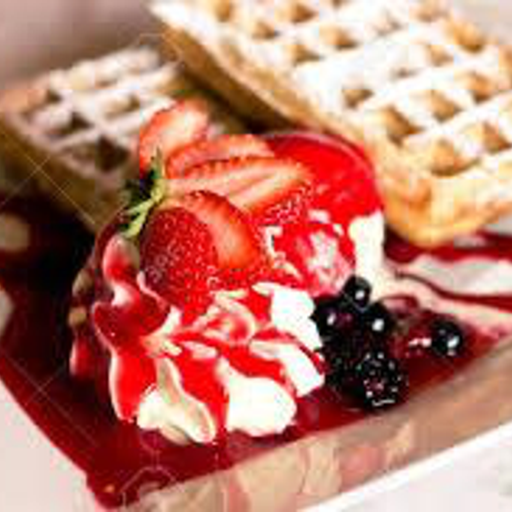

In [54]:
#1 

topk = 70
url = 'http://glovo.away.guru/photos_resized/GVRWVQY_0003489_1617838725.png'
top_text = search_image(url,head=topk)
image = read_image_from_url(url);image

In [55]:
top_text

,id,description,category,energy,protein,carb,fat,clip,score
0,1101485,"Waffle, fruit","Pancakes, waffles, French toast",304.0,6.96,36.23,14.78,"[0.024078026, -0.01843561, -0.007544476, -0.00...",0.272083
1,1101481,"Waffle, fruit, from fast food / restaurant","Pancakes, waffles, French toast",350.0,6.62,34.45,20.95,"[0.038318176, -0.005637003, 0.002802879, 0.003...",0.264517
2,1101472,"Waffle, plain, reduced fat, from frozen","Pancakes, waffles, French toast",289.0,9.42,46.20,6.92,"[0.019080585, 0.017776603, -0.0057641263, 0.02...",0.263972
3,1101491,"Waffle, plain, reduced fat","Pancakes, waffles, French toast",339.0,9.03,42.88,14.47,"[0.018091468, 0.016758496, -0.0005849448, -0.0...",0.261712
4,1101476,"Waffle, whole grain, reduced fat, from frozen","Pancakes, waffles, French toast",257.0,7.14,49.16,3.57,"[0.007625108, -0.0047698068, -0.016695984, 0.0...",0.254693
...,...,...,...,...,...,...,...,...,...
65,1103951,Chocolate syrup,"Jams, syrups, toppings",269.0,0.00,67.21,0.00,"[0.02195843, -0.0036228136, -0.0024154084, 0.0...",0.203969
66,1101188,"Pastry, fruit-filled","Doughnuts, sweet rolls, pastries",393.0,4.57,54.30,19.36,"[0.02611203, -0.022645308, 0.018223003, 0.0177...",0.203930
67,1097887,"Cream, half and half, fat free",Cream and cream substitutes,59.0,2.60,9.00,1.40,"[0.028938714, 0.023712644, 0.0074179866, 0.001...",0.203500
68,1102857,"Mixed fruit yogurt dessert, baby food, strained",Baby food: yogurt,75.0,0.80,16.23,0.80,"[-0.013352567, 0.017778194, 0.019533033, 0.028...",0.203080


In [56]:
import torch
import gdown
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


In [57]:
from clip_ods import clip, CLIPDetectorV1

In [58]:
device = torch.device('cpu')
model, preprocess = clip.load("RN50x4", device=device)  # "ViT-B/32","RN50","RN101","RN50x4"
clip_detector = CLIPDetectorV1(model, preprocess, device)

In [59]:
coords, masks = clip_detector.get_coords_and_masks(image)
anchor_features = clip_detector.get_anchor_features(image, coords)

100%|██████████| 41/41 [02:02<00:00,  3.00s/it]


In [60]:
coords.shape

(1287, 4)

In [67]:
n = 0
text = 'cream'#top_text['description'].iloc[n]#'dish' #

In [68]:

result = clip_detector.detect_by_text(
    texts=[text],
    img=image,
    coords=coords, masks=masks,
    anchor_features=anchor_features,
    skip_box_thr=0.7
)
colour = (0,255,0)


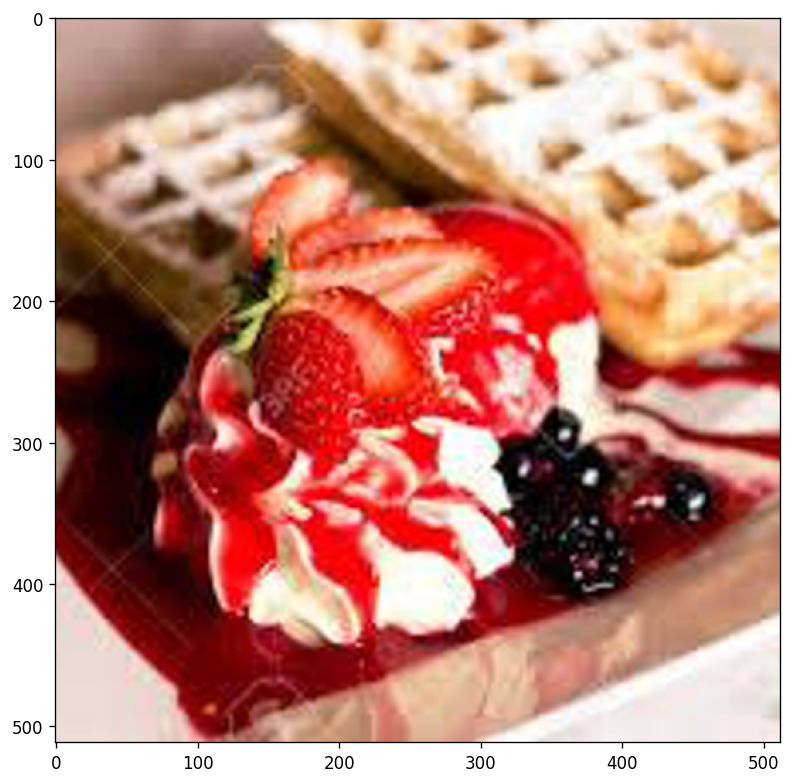

In [69]:

img = clip_detector.draw(
    image, 
    result,
    label=text,
    colour=colour,
    font_colour=colour,
    font_scale=0.5, 
    font_thickness=1,
)

plt.figure(num=None, figsize=(8, 8), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(img)

In [ ]:

r = pd.DataFrame()

#2
clip = series2tensor(top_text['clip'])
top_text['score1'] =cos(clip, clip[0])
top_text['score2'] =cos(clip, clip[top_text.sort_values("score1",ascending=False).iloc[-1].name])
for i in range(3,n_farthest+1):
    top_text[f'score{i}'] =cos(clip, clip[top_text[top_text.columns[top_text.columns.str.contains('score')]]         .sum(1).sort_values().index[0]])
farthest = top_text[(top_text[top_text.columns[top_text.columns.str.contains('score')]]==1).any(1)][['description','clip']]
# farthest = top_text
while len(farthest)>0:
    clip = series2tensor(farthest['clip'])
    farthest['score'] = cos(clip, clip[0])
    farthest.loc[farthest['score']>clustering_similarity,'res'] = farthest['description'].iloc[0]
    r = r.append(farthest[farthest['score']>clustering_similarity].drop(columns = ['score']))
    farthest = farthest[farthest['score']<clustering_similarity]
rr = r.groupby('res')['description'].count().sort_values(ascending=False);rr

In [40]:
'. '.join(rr.index.tolist())

"Roll, Mexican, bolillo. Sushi, topped with crab. Beef, rice, and vegetables excluding carrots, broccoli, and dark-green leafy; no sauce. Fish, tofu, and vegetables, tempura. Jai, Monk's Food. Luncheon meat, NFS. Roll, white, hard. Summer squash, yellow or green, frozen, cooked, fat added, NS as to fat type. Sushi, NFS. Wasabi paste"

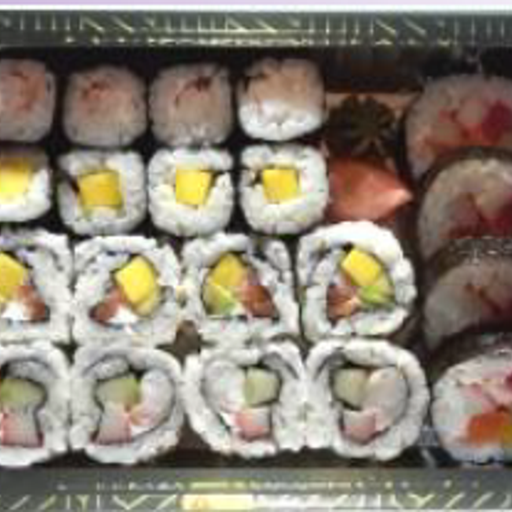

In [14]:
from transformers import AutoTokenizer, AutoModelWithLMHead, SummarizationPipeline


In [16]:

pipeline = SummarizationPipeline(
    model=AutoModelWithLMHead.from_pretrained("SEBIS/code_trans_t5_small_program_synthese_transfer_learning_finetune"),
    tokenizer=AutoTokenizer.from_pretrained("SEBIS/code_trans_t5_small_program_synthese_transfer_learning_finetune", skip_special_tokens=True),
    # device=0
)


'Fish, NS as to type, baked or broiled, made with margarineFish fillet, fried as ingredient in sandwichesFish in lemon-butter sauce with starch item, vegetable, frozen mealFlounder, coated, fried, made with cooking sprayPerch, coated, fried, made with margarinePompano, coated, baked or broiled, no added fatPorgy, baked or broiled, no added fatWhiting, baked or broiled, made with cooking spray'

In [26]:

tokenized_code = ' '.join(aa)
pipeline([tokenized_code])

[{'summary_text': '[ + [ + [ * [ - [ floor [ sqrt [ + [ * [ - ['}]

In [27]:
tokenized_code

'Fish, NS as to type, baked or broiled, made with margarine Fish fillet, fried as ingredient in sandwiches Fish in lemon-butter sauce with starch item, vegetable, frozen meal Flounder, coated, fried, made with cooking spray Perch, coated, fried, made with margarine Pompano, coated, baked or broiled, no added fat Porgy, baked or broiled, no added fat Whiting, baked or broiled, made with cooking spray'

res
Fish, NS as to type, baked or broiled, made with margarine             6
Fish fillet, fried as ingredient in sandwiches                         1
Fish in lemon-butter sauce with starch item, vegetable, frozen meal    1
Flounder, coated, fried, made with cooking spray                       1
Perch, coated, fried, made with margarine                              1
Pompano, coated, baked or broiled, no added fat                        1
Porgy, baked or broiled, no added fat                                  1
Whiting, baked or broiled, made with cooking spray                     1
Name: description, dtype: int64

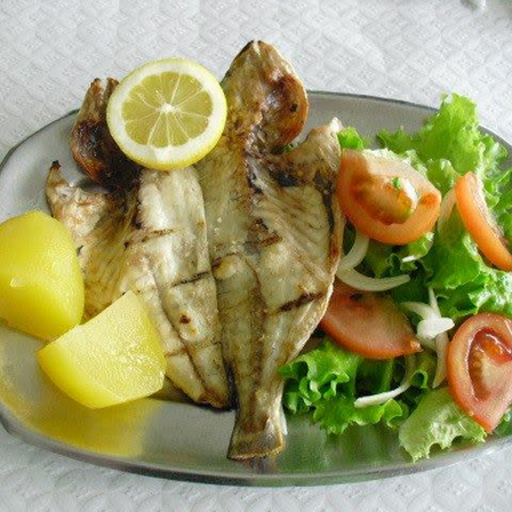

In [107]:
!nbdev_build_lib

Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_classfy_image.ipynb.
Converted 0_template copy.ipynb.
Converted 0_template.ipynb.
Converted Untitled-1.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
Converted usda_parsing.ipynb.
